In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import random
import matplotlib.pyplot as plt

In [2]:
# hyper-parameters
BATCH_SIZE = 128
LR = 0.01
GAMMA = 0.90 
EPISILON = 0.9
MEMORY_CAPACITY = 20000 #You can try bigger
Q_NETWORK_ITERATION = 100


env = gym.make("CartPole-v0")
env = env.unwrapped
NUM_ACTIONS = env.action_space.n
NUM_STATES = env.observation_space.shape[0]
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample.shape

/Users/egor.bazhenov/PycharmProjects/RL/venv/lib/python3.9/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


Need to collect (actions, states, rewards, next_statex)....
episode: 0 , the episode reward is 13.0
episode: 1 , the episode reward is 9.0
episode: 2 , the episode reward is 9.0
episode: 3 , the episode reward is 8.0
episode: 4 , the episode reward is 10.0
episode: 5 , the episode reward is 10.0
episode: 6 , the episode reward is 10.0
episode: 7 , the episode reward is 8.0
episode: 8 , the episode reward is 10.0
episode: 9 , the episode reward is 9.0
episode: 10 , the episode reward is 9.0
episode: 11 , the episode reward is 10.0
episode: 12 , the episode reward is 9.0
episode: 13 , the episode reward is 9.0
episode: 14 , the episode reward is 9.0
episode: 15 , the episode reward is 8.0
episode: 16 , the episode reward is 9.0
episode: 17 , the episode reward is 10.0
episode: 18 , the episode reward is 9.0
episode: 19 , the episode reward is 9.0
episode: 20 , the episode reward is 9.0
episode: 21 , the episode reward is 11.0
episode: 22 , the episode reward is 9.0
episode: 23 , the epis

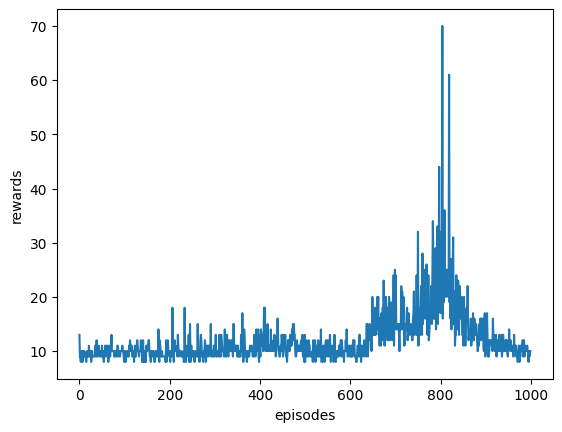

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(NUM_STATES, 50)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(50, 30)
        self.fc2.weight.data.normal_(0, 0.1)
        self.out = nn.Linear(30, NUM_ACTIONS)
        self.out.weight.data.normal_(0, 0.1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        action_prob = self.out(x)
        return action_prob


class DQN:
    def __init__(self):
        super(DQN, self).__init__()
        self.eval_net = Net()
        self.target_net = Net()  # We need a target_net for stable evaluation.
        self.learn_step_counter = 0
        self.memory_counter = 0
        self.memory = np.zeros((MEMORY_CAPACITY, NUM_STATES * 2 + 2))
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=0.001, weight_decay=1e-05)
        self.loss_func = torch.nn.MSELoss()

    def choose_action(self, state):
        state = torch.FloatTensor(state)
        if random.random() < (1 - EPISILON):
            return random.choice(range(NUM_ACTIONS))
        else:
            with torch.no_grad():
                action = self.eval_net(state)
        return np.argmax(action).item()

    def store_transition(self, state, action, reward, next_state):
        transition = np.hstack((state, [action, reward], next_state))
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memory_counter += 1

    def update(self):
        #sample batch from memory
        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        batch_memory = self.memory[sample_index, :]
        batch_state = torch.FloatTensor(batch_memory[:, :NUM_STATES])
        batch_action = torch.LongTensor(batch_memory[:, NUM_STATES:NUM_STATES + 1].astype(int))
        batch_reward = torch.FloatTensor(batch_memory[:, NUM_STATES + 1:NUM_STATES + 2])
        batch_next_state = torch.FloatTensor(batch_memory[:, -NUM_STATES:])

        for state, action, reward, next_state in zip(batch_state, batch_action, batch_reward, batch_next_state):
            predictions = self.eval_net(state)
            target = reward + GAMMA * torch.max(predictions).item()
            with torch.no_grad():
                target_q = self.target_net(next_state)
                target_q[action] = target
            loss = self.loss_func(predictions, target_q)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        #update the target network parameters
        if self.learn_step_counter % Q_NETWORK_ITERATION == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1


def train():
    dqn = DQN()
    episodes = 1000
    x = []
    y = []
    print("Need to collect (actions, states, rewards, next_statex)....")
    for i in range(episodes):
        x.append(i)
        state = env.reset()[0]
        ep_reward = 0
        while True:
            env.render()
            action = dqn.choose_action(state)

            observation, reward, terminated, truncated, info = env.step(action)

            dqn.store_transition(state, action, reward, observation)
            ep_reward += reward

            dqn.update()

            if terminated:
                print("episode: {} , the episode reward is {}".format(i, round(ep_reward, 3)))
                y.append(ep_reward)
                break
            state = observation
    return [x, y]


x, y = train()
plt.plot(x, y)
plt.ylabel('rewards')
plt.xlabel('episodes')
plt.show()